In [ ]:
!pip install joblib  # Required to save models in HDF5 format

In [ ]:
!pip install retina-face

# **PREPARATION**

In [ ]:
import tensorflow as tf
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import f1_score as f1
from google.colab import drive

import pandas as pd
import numpy as np
from PIL import Image, ImageOps
from google.colab.patches import cv2_imshow
import cv2 as cv
import glob
import os
import random

from skimage.io import imread
from skimage.transform import resize
from skimage.feature import hog
from skimage import exposure
import matplotlib.pyplot as plt

from joblib import dump, load
from retinaface import RetinaFace

In [ ]:
# random.seed(10)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**NHỚ SỬA LẠI ĐƯỜNG DẪN DƯỚI ĐÂY SAO CHO ĐÚNG VỚI DRIVE CỦA MÌNH**

In [ ]:
# !unzip "/content/drive/MyDrive/Final Project/FER2013.zip"

In [ ]:
def Convert_Img(image_files, img_dimensions=(128, 128, 3)):
   # data = []
    labels = []
    for img in image_files:

        # image = cv.imread(img)

        # image = cv.resize(image, (img_dimensions[0],img_dimensions[1]))
        # image = tf.keras.utils.img_to_array(image)
        # data.append(image)

        label = img.split(os.path.sep)[-2]
        if label == "angry": label = 0
        elif label == "disgust": label = 1
        elif label == "fear": label = 2
        elif label == "happy": label = 3
        elif label == "neutral": label = 4
        elif label == "sad": label = 5
        elif label == "surprise": label = 6
        labels.append([label]) # [[1], [0], [0], ...]
    return labels

# **SPLIT DATASET INTO TRAIN AND TEST SETS**

In [ ]:
# def DataInit(folder_path, data_size):
#   image_files = [f for f in glob.glob(folder_path + "/**/*", recursive=True) if not os.path.isdir(f)]
#   random.shuffle(image_files)
#   y = Convert_Img(image_files[:data_size])
#   X = np.array(X) / 255
#   y = np.array(y)
#   return y

In [ ]:
# X_train, y_train = DataInit("train", 28709)

In [ ]:
# X_test, y_test = DataInit("test", 7178)

In [ ]:
# y_train = DataInit("train", 28709)

In [ ]:
# y_test = DataInit("test", 7178)

In [ ]:
# dump(y_train, "y_train.joblib")

['y_train.joblib']

In [ ]:
# dump(y_test, "y_test.joblib")

['y_test.joblib']

# **EXTRACT H.O.G FROM IMAGES AND SAVE TO JOBLIB FILES**

In [ ]:
# def compute_HOG(arr):
#     features =[]
#     count = 1
#     for img in arr:
#         fd, hog_image = hog(img, orientations=9, pixels_per_cell=(8, 8),
#                 	cells_per_block=(2, 2), visualize=True, multichannel=True)
#         fd = np.array(fd)
#         features.append(fd)
#         print(count)
#         count += 1
#     return np.array(features)

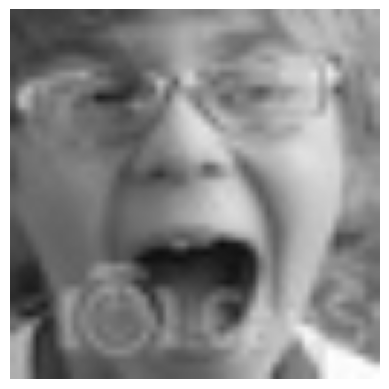

In [ ]:
# plt.axis("off")
# plt.imshow(cv.cvtColor(X_train[0], cv.COLOR_BGR2RGB))
# plt.show()

In [ ]:
# img = X_train[0]

In [ ]:
# y_train[0]

array([0])

<ipython-input-17-4eb872cbe074>:1: FutureWarning: `multichannel` is a deprecated argument name for `hog`. It will be removed in version 1.0. Please use `channel_axis` instead.
  fd, hog_image = hog(img, orientations=9, pixels_per_cell=(8, 8),


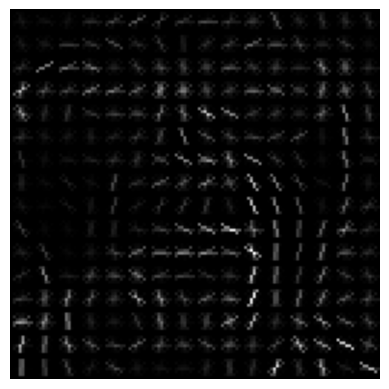

In [ ]:
# fd, hog_image = hog(img, orientations=9, pixels_per_cell=(8, 8),
#                 	cells_per_block=(2, 2), visualize=True, multichannel=True)
# plt.axis("off")
# plt.imshow(hog_image, cmap="gray")
# plt.show()

In [ ]:
%%capture
# X_train = compute_HOG(X_train)

In [ ]:
# dump(X_train, "X_train.joblib")

['X_train.joblib']

hog feature in dataset

In [ ]:
%%capture
# X_test = compute_HOG(X_test)

In [ ]:
# dump(X_test, "X_test.joblib")

['X_test.joblib']

# **LOAD HOG DATA**

In [ ]:
X_train = load("/content/drive/MyDrive/Final Project/X_train.joblib")

In [ ]:
X_test = load("/content/drive/MyDrive/Final Project/X_test.joblib")

In [ ]:
y_train = load("/content/drive/MyDrive/Final Project/y_train.joblib")

In [ ]:
y_test = load("/content/drive/MyDrive/Final Project/y_test.joblib")

In [ ]:
print("Size of features' train set: ", X_train.shape)
print("Size of target's train set: ", y_train.shape)
print("Size of features' test set: ", X_test.shape)
print("Size of target's test set", y_test.shape)

Size of features' train set:  (28709, 8100)
Size of target's train set:  (28709, 1)
Size of features' test set:  (7178, 8100)
Size of target's test set (7178, 1)


In [ ]:
count_angry = count_disgust = count_fear = count_happy = count_neutral = count_sad = count_surprise = 0
for i in y_train:
  if i == 0: count_angry += 1
  elif i == 1: count_disgust += 1
  elif i == 2: count_fear += 1
  elif i == 3: count_happy += 1
  elif i == 4: count_neutral += 1
  elif i == 5: count_sad += 1
  else: count_surprise += 1
labels = {"angry": count_angry, "disgust": count_disgust, "fear": count_fear, "happy": count_happy,
          "neutral": count_neutral, "sad": count_sad, "surprise": count_surprise}

for i, j in labels.items():
  print(f"Number of images labeled as {i} is:", j)

Number of images labeled as angry is: 3995
Number of images labeled as disgust is: 436
Number of images labeled as fear is: 4097
Number of images labeled as happy is: 7215
Number of images labeled as neutral is: 4965
Number of images labeled as sad is: 4830
Number of images labeled as surprise is: 3171


# **SOFTMAX REGRESSION**

In [ ]:
log_reg_model = LogisticRegression(multi_class='multinomial', max_iter = 1000000000000, random_state=42)
log_reg_model.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(max_iter=1000000000000, multi_class='multinomial',
                   random_state=42)

In [ ]:
# accuracy on test set
acc_test = log_reg_model.score(X_test, y_test)
print(acc_test)

0.3780997492337699


In [ ]:
dump(log_reg_model, "log_reg_model.joblib")

['log_reg_model.joblib']

# **K NEAREST NEIGHBORS**

In [ ]:
acc_list = list()

In [ ]:
for k in range(1, 41):
  model_KNN = KNeighborsClassifier(n_jobs=-1, n_neighbors=k)
  model_KNN.fit(X_train, y_train)
  y_pred = model_KNN.predict(X_test)
  acc_list.append(accuracy_score(y_test, y_pred))
  print(k)
acc_list = np.array(acc_list)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100


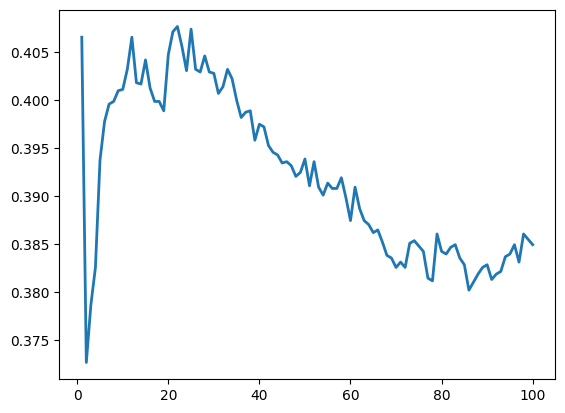

In [ ]:
plt.plot(np.array([i for i in range(1, 101)]), acc_list, linewidth=2)

In [ ]:
print("Max accuracy is ", max(acc_list), " at k=", list(acc_list).index(max(acc_list))+1)

Max accuracy is  0.4076344385622736  at k= 22


# **SUPPORT VECTOR MACHINE**

In [ ]:
model_rbf = svm.SVC(kernel='rbf')
model_rbf.fit(X_train, y_train)

SVC()

In [ ]:
dump(model_rbf, "svm_rbf.joblib")

['svm_rbf.joblib']

In [ ]:
y_pred = model_rbf.predict(X_test)

In [ ]:
cm = confusion_matrix(y_test, y_pred)
print(cm)
print(accuracy_score(y_test, y_pred))

[[237   0  55 116  91 144  11]
 [ 27  13   9  11   4  14   2]
 [ 81   0 191 114 109 179  58]
 [ 53   0  44 934  58 115  23]
 [ 50   0  53 166 426 162  15]
 [ 83   0  62 174 146 389   9]
 [ 26   0  48  61  45  42 350]]
0.508


In [ ]:
print(f1(y_test, y_pred, average=None))

[0.39141206 0.27956989 0.319933   0.66642883 0.4865791  0.40775681
 0.67307692]


In [ ]:
dump(model_rbf, "svm_rbf_model.joblib")

['svm_rbf_model.joblib']

In [ ]:
from google.colab import files
files.download('svm_rbf_model.joblib')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# **RANDOM FOREST**

In [ ]:
model_RR = RandomForestClassifier(n_estimators=2000, random_state=42, n_jobs=-1)
model_RR.fit(X_train, y_train)

<ipython-input-9-514d12c108bc>:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model_RR_2.fit(X_train, y_train)


RandomForestClassifier(n_estimators=2000, n_jobs=-1, random_state=42)

In [ ]:
y_pred = model_RR.predict(X_test)

In [ ]:
cm = confusion_matrix(y_test, y_pred)
print(cm)
print(accuracy_score(y_test, y_pred))

[[ 430    0    2  303  168   39   16]
 [   4    0   10   71   18    8    0]
 [  39    5  119  556  196  109    0]
 [  48    0    7 1443  185   90    1]
 [  46    0   12  558  472  145    0]
 [  77    0    3  538  236  393    0]
 [ 345    0    0  336  102   34   14]]
0.39997213708553914


# **DEMO**

In [ ]:
demo4 = '/content/drive/MyDrive/Final Project/demo_4.jpg'
demo10 = '/content/drive/MyDrive/Final Project/demo_10.jpg'

In [ ]:
model_svm = load('/content/drive/MyDrive/Final Project/svm_rbf_model.joblib')

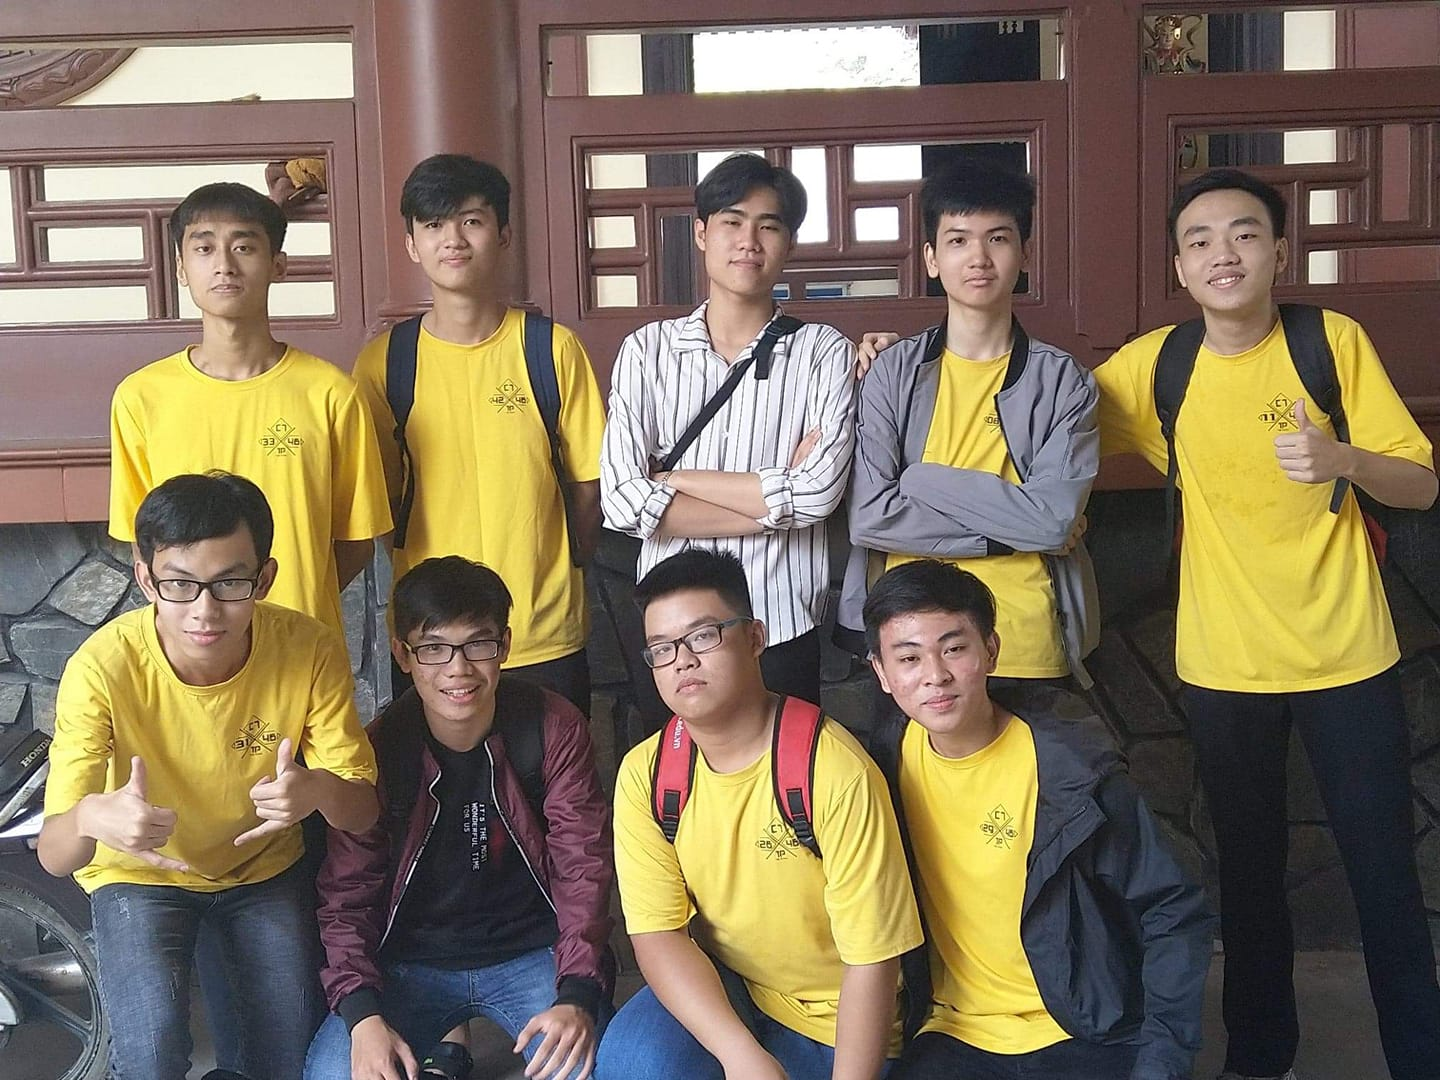

In [ ]:
cv2_imshow(cv.imread(demo4))

In [ ]:
import matplotlib.pyplot as plt
def demo(image_path, model=model_svm):
    faces = RetinaFace.detect_faces(image_path)
    img_1 = ImageOps.exif_transpose(Image.open(image_path))
    crops = []
    for key, value in faces.items():
        face_coord = faces[key]['facial_area']
        crops.append(np.array(img_1)[face_coord[1]:face_coord[3], face_coord[0]:face_coord[2]])

    predictions = []
    for i, crop in enumerate(crops):
        gray = cv.cvtColor(crop, cv.COLOR_BGR2GRAY)
        gray = cv.resize(gray, (48, 48))
        cv2_imshow(gray)

        # Phóng to ảnh sử dụng phép nội suy Lanczos
        demo_image = cv.resize(gray, (128, 128), interpolation=cv.INTER_LANCZOS4)
        demo_image = tf.keras.utils.img_to_array(demo_image)
        demo_image = demo_image / 255
        demo_image, hog_image = hog(demo_image, orientations=9, pixels_per_cell=(8, 8),
                                    cells_per_block=(2, 2), visualize=True, multichannel=True)
        demo_image = np.array(demo_image)
        demo_image = demo_image.reshape(1, -1)
        pred = model.predict(demo_image)
        label = ""
        if pred == 0:
            label = "angry"
        elif pred == 1:
            label = "disgust"
        elif pred == 2:
            label = "fear"
        elif pred == 3:
            label = "happy"
        elif pred == 4:
            label = "neutral"
        elif pred == 5:
            label = "sad"
        elif pred == 6:
            label = "surprise"
        predictions.append(label)
    # Hiển thị ảnh với nhãn tương ứng
        plt.imshow(gray, cmap='gray')
        plt.title("Label: " + label)
        plt.axis('off')
        plt.show()
    print("Độ dài của danh sách predictions:", len(predictions))
    return predictions



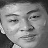

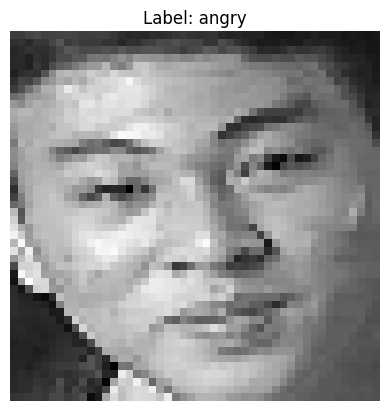

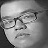

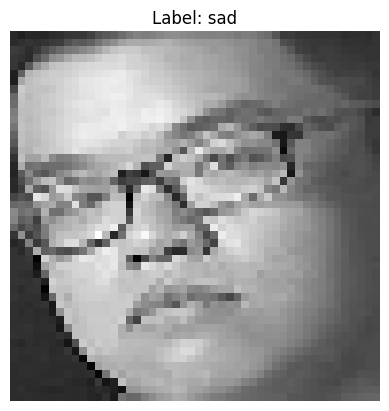

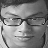

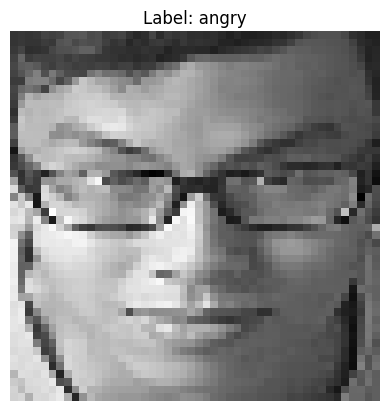

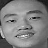

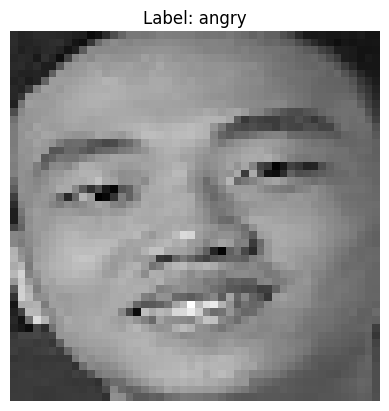

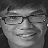

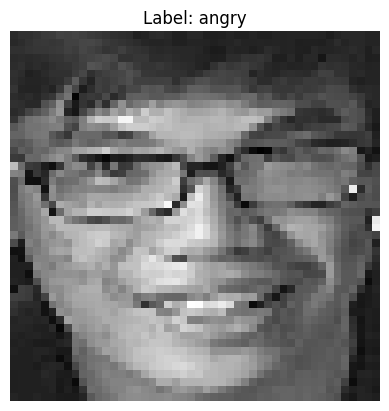

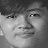

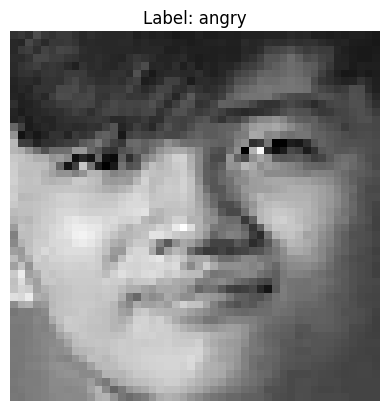

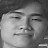

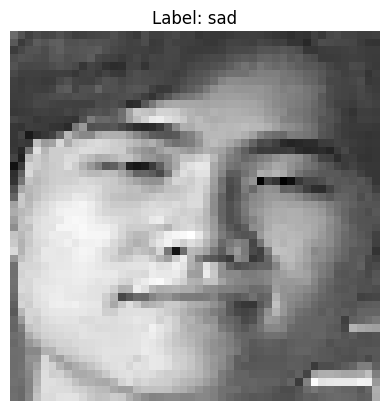

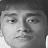

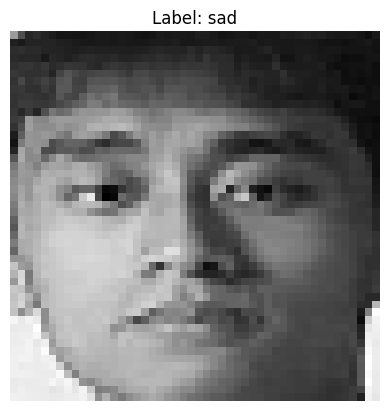

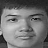

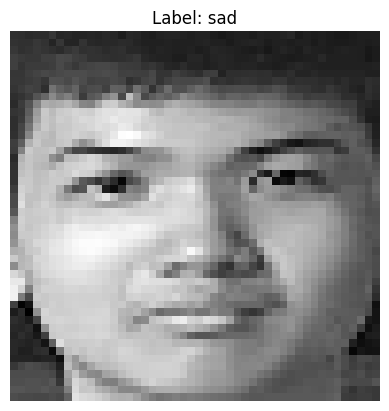

Độ dài của danh sách predictions: 9


['angry', 'sad', 'angry', 'angry', 'angry', 'angry', 'sad', 'sad', 'sad']

In [ ]:
demo(demo4)

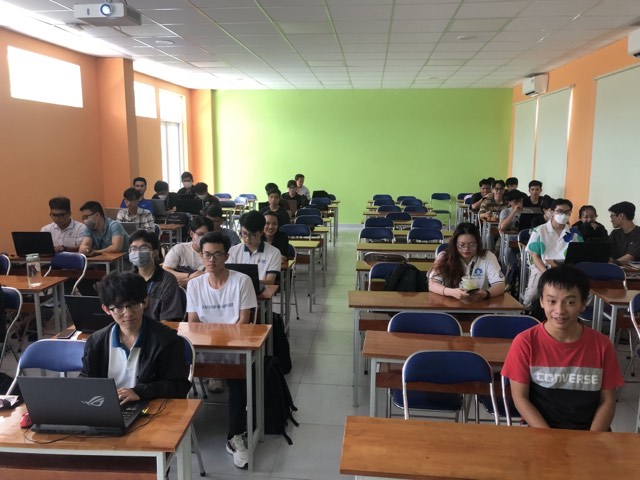

Số lượng ảnh đã in ra: 0


In [ ]:
cv2_imshow(cv.imread(demo10))

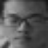

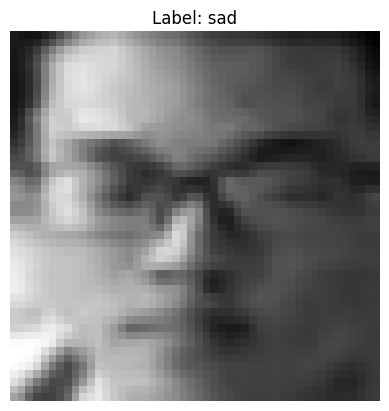

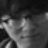

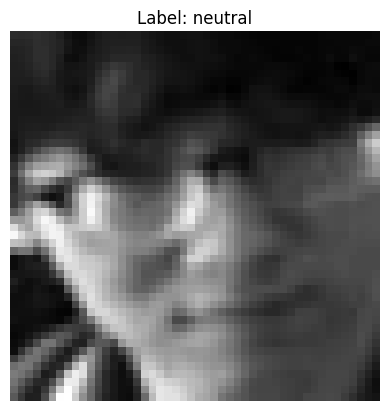

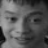

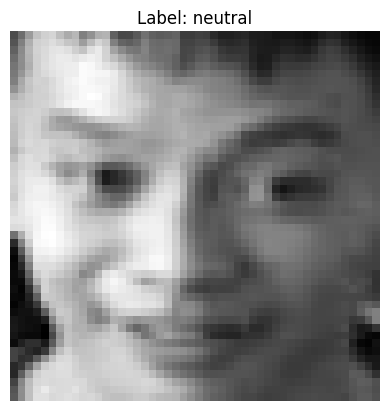

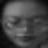

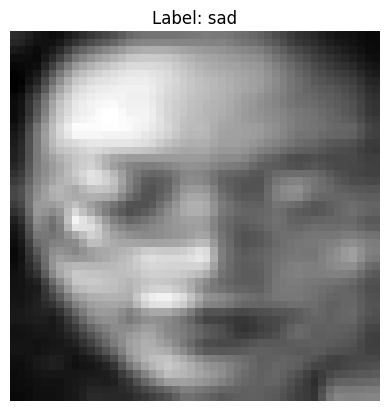

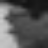

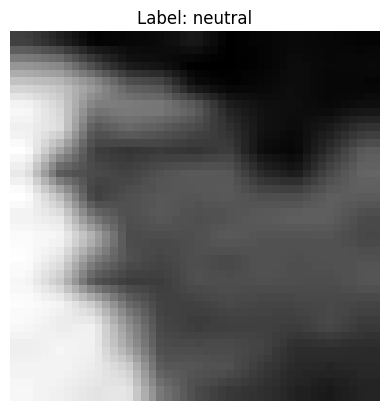

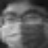

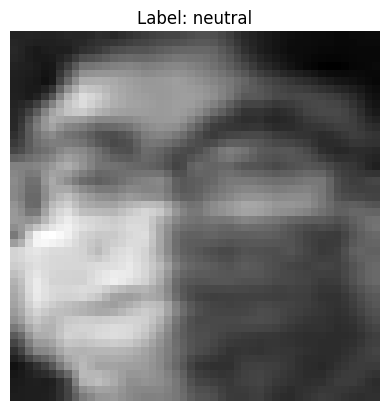

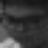

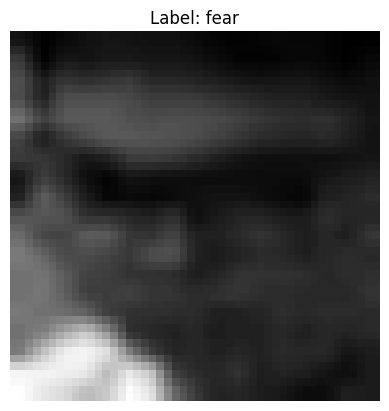

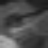

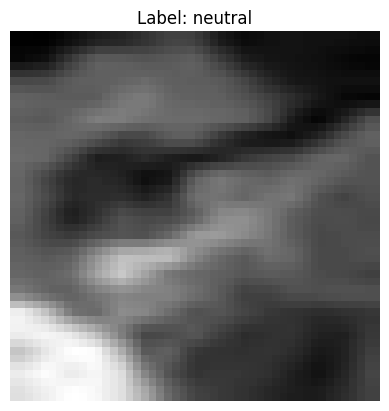

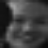

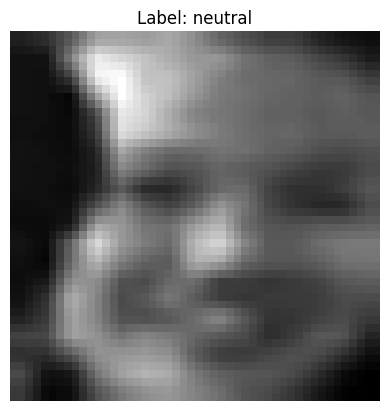

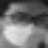

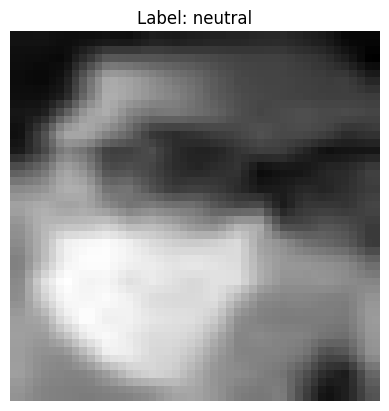

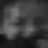

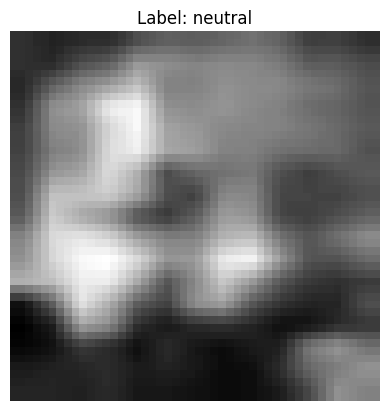

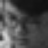

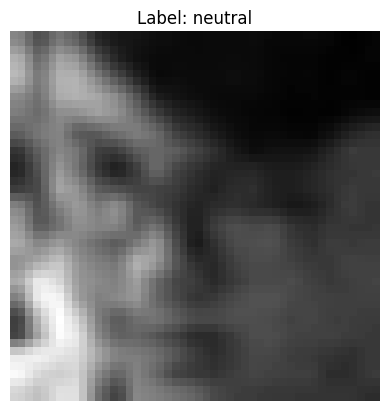

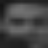

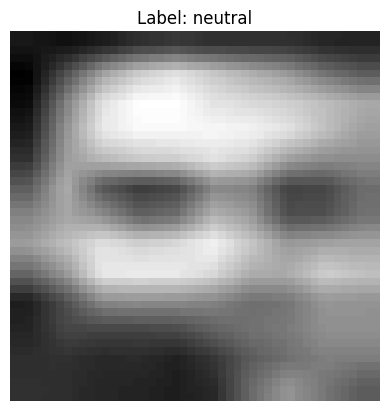

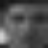

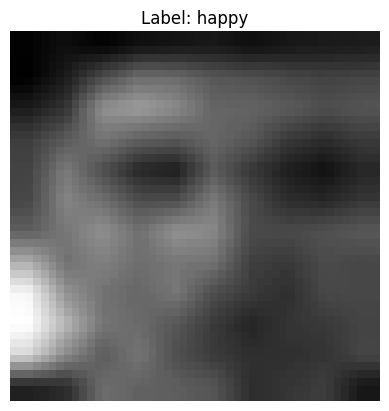

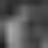

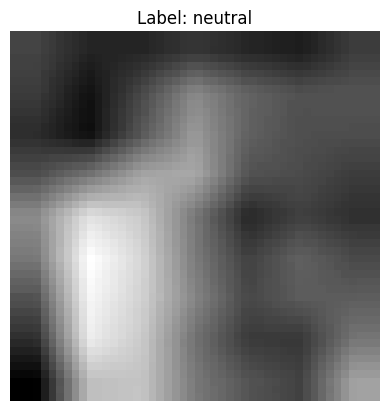

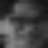

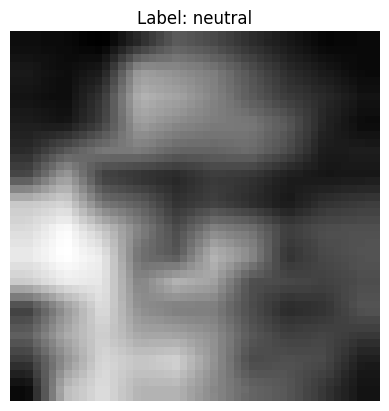

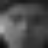

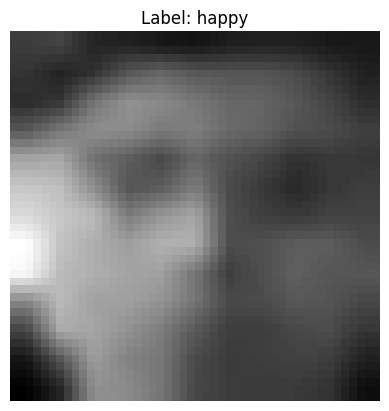

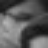

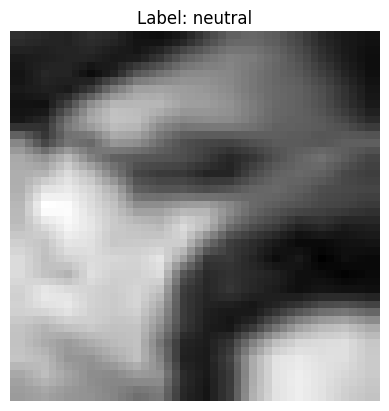

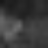

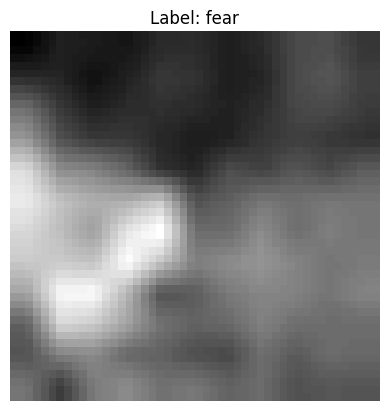

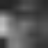

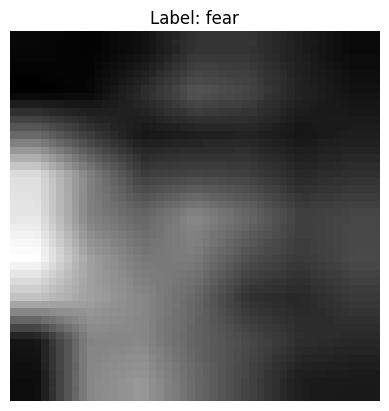

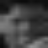

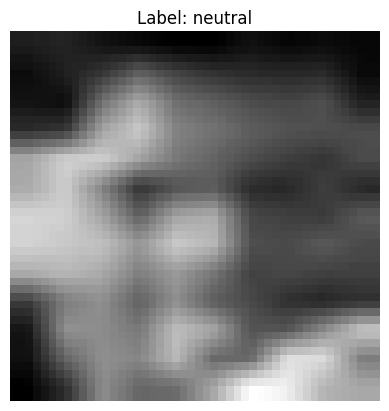

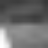

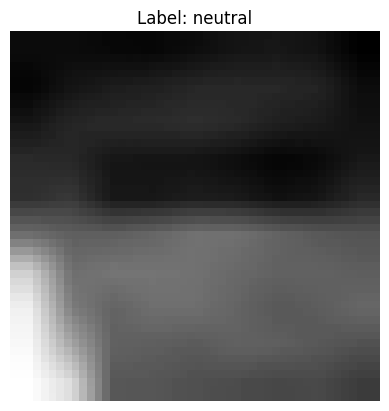

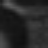

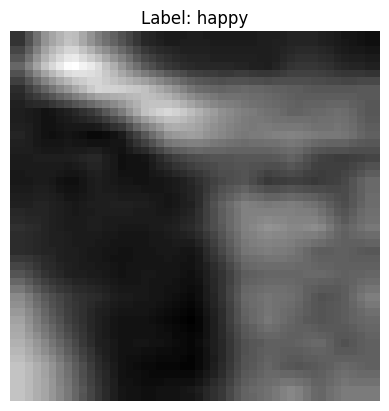

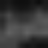

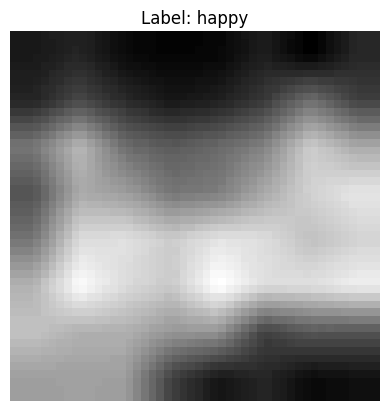

Độ dài của danh sách predictions: 24


['sad',
 'neutral',
 'neutral',
 'sad',
 'neutral',
 'neutral',
 'fear',
 'neutral',
 'neutral',
 'neutral',
 'neutral',
 'neutral',
 'neutral',
 'happy',
 'neutral',
 'neutral',
 'happy',
 'neutral',
 'fear',
 'fear',
 'neutral',
 'neutral',
 'happy',
 'happy']

In [ ]:
demo(demo10)